In [1]:
import math
import torch

from tqdm.notebook import tqdm
from PIL import Image, ImageOps

from diffusers import DDIMScheduler, DDIMInverseScheduler
from external_mask_extractor import ExternalMaskExtractor
from pipeline_stable_diffusion_grounded_instruct_pix2pix import StableDiffusionInstructPix2PixPipeline


from transformers import logging
logging.set_verbosity_error()

In [2]:
def load_pil_image(image_path, resolution=512):
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    factor = resolution / max(width, height)
    factor = math.ceil(min(width, height) * factor / 64) * 64 / min(width, height)
    width = int((width * factor) // 64) * 64
    height = int((height * factor) // 64) * 64
    image = ImageOps.fit(image, (width, height), method=Image.Resampling.LANCZOS)
    return image

In [3]:
# mask extractor
device = 'cuda:0'
mask_extractor = ExternalMaskExtractor(device=device)


# pipeline
num_timesteps = 100
pipeline = StableDiffusionInstructPix2PixPipeline.from_pretrained("timbrooks/instruct-pix2pix",
                                                                  torch_dtype=torch.float16,
                                                                  safety_checker=None).to(device)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config, set_alpha_to_zero=False)

pipeline.scheduler.set_timesteps(num_timesteps)
pipeline.inverse_scheduler.set_timesteps(num_timesteps)

/home/artur.shagidanov/text-guided-image-editing/Grounded-Instruct-Pix2Pix/gip2p_venv/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


The config attributes {'algorithm_type': 'dpmsolver++', 'dynamic_thresholding_ratio': 0.995, 'lower_order_final': True, 'sample_max_value': 1.0, 'set_alpha_to_one': False, 'skip_prk_steps': True, 'solver_order': 2, 'solver_type': 'midpoint', 'thresholding': False} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [4]:
def inference(pipeline, image_pil, instruction, 
              image_guidance_scale, text_guidance_scale, seed, blending_range):
    external_mask_pil, chosen_noun_phrase, clip_scores_dict = mask_extractor.get_external_mask(image_pil, instruction, verbose=verbose)

    inv_results = pipeline.invert(instruction, image_pil, num_inference_steps=num_timesteps, inv_range=blending_range)

    generator = torch.Generator(device).manual_seed(seed) if seed is not None else torch.Generator(device)
    edited_image = pipeline(instruction, src_mask=external_mask_pil, image=image_pil,
                            guidance_scale=text_guidance_scale, image_guidance_scale=image_guidance_scale,
                            num_inference_steps=num_timesteps, generator=generator).images[0]
    return edited_image

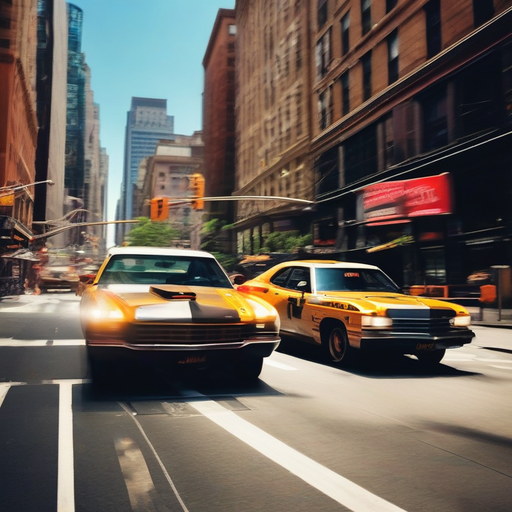

/home/artur.shagidanov/text-guided-image-editing/Grounded-Instruct-Pix2Pix/gip2p_venv/lib/python3.9/site-packages/transformers/modeling_utils.py:866: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/artur.shagidanov/text-guided-image-editing/Grounded-Instruct-Pix2Pix/gip2p_venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/100 [00:00<?, ?it/s]

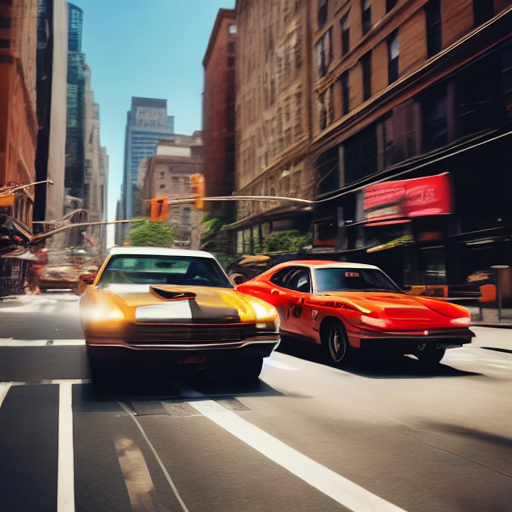

In [5]:
# the default values of Instruct-Pix2Pix are a good starting point,
# but you can often get better results with higher guidance_scale

verbose = False
image_path = './src/two_cars_racing.png'
edit_instruction = 'replace the right car with a red Ferrari'
image_guidance_scale = 1.5
guidance_scale = 7.5
# here, steps are defined w.r.t. num_train_steps(=1000)
start_blending_at_tstep = 100
end_blending_at_tstep   = 1
blending_range = [start_blending_at_tstep, end_blending_at_tstep]
seed = 42


image = load_pil_image(image_path)
image.show()

edited_image = inference(pipeline, image, edit_instruction, image_guidance_scale, 
                         guidance_scale, seed, blending_range)
edited_image.show()

  0%|          | 0/100 [00:00<?, ?it/s]

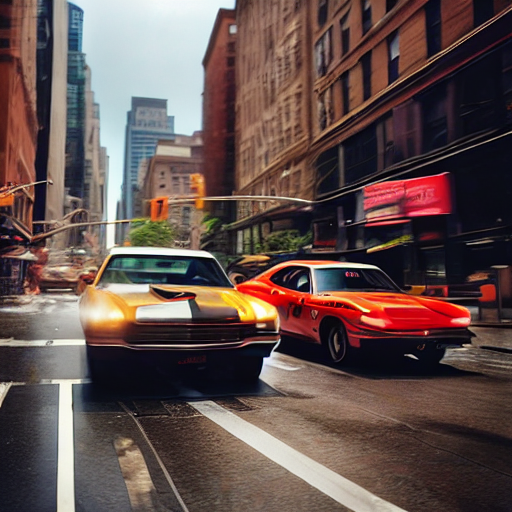

In [6]:
verbose = False
edit_instruction = 'turn the weather rainy'
image_guidance_scale = 1.5
text_guidance_scale  = 7.5
# here, steps are defined w.r.t. num_train_steps(=1000)
start_blending_at_tstep = 100
end_blending_at_tstep   = 1
blending_range = [start_blending_at_tstep, end_blending_at_tstep]
seed = 42

edited_image_2 = inference(pipeline, edited_image, edit_instruction, image_guidance_scale, 
                         text_guidance_scale, seed, blending_range)
edited_image_2.show()